# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices

## Getting Started
In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Let's run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. We will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, we will make a cursory investigation about the Boston housing data and provide observations.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
For our very first coding implementation, we will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported, let's use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In [2]:
np_price = np.asarray(prices)

# Minimum price of the data
minimum_price = np_price.min()

# Maximum price of the data
maximum_price = np_price.max()

# Mean price of the data
mean_price = np_price.mean()

# Median price of the data
median_price = np.median(np_price)

# Standard deviation of prices of the data
std_price = np_price.std()

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price:                ${}".format(minimum_price)) 
print("Maximum price:                ${}".format(maximum_price))
print("Mean price:                   ${}".format(mean_price))
print("Median price                  ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price:                $105000.0
Maximum price:                $1024800.0
Mean price:                   $454342.9447852761
Median price                  $438900.0
Standard deviation of prices: $165171.13154429474


### Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

**Question:** Would we expect a home that has an `'RM'` value(number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?

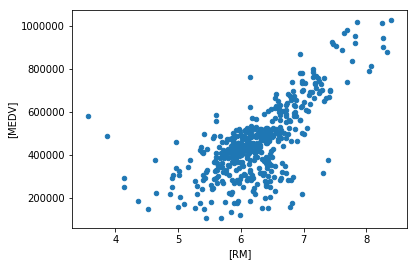

In [3]:
data.plot(x=['RM'], y=['MEDV'], kind='scatter');

**Answer:** Above is a scatter plot plotted between 'RM' and 'MEDV'.

It can be understood that more the Number of Rooms higher the Price of Owner-Occupied House. Ofcourse this is a universal known fact anyways. It is also found that there is huge concentration in the middle of the graph which means that a large population lies in that area.

Hence to answer the question, we can expect a home with a `'RM'` value of 6 be worth less than a home with `'RM'` value of 7.

**Question:** Would we expect a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?

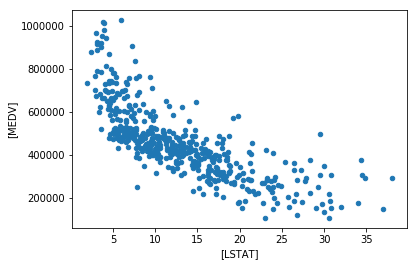

In [4]:
data.plot(x=['LSTAT'], y=['MEDV'], kind='scatter');

**Answer:** Above is the scatter plot plotted between 'LSTAT' and 'MEDV'. The plot is concentrated more on the Left Bottom side more.

It can be understood that Higher the Lower Status Population Lower the Price of Owner Occupied House. Ofcourse Lower Status population can buy Lower Price houses. These 2 attributes are Inversely Proportional to each other.

Hence to answer the question, a Home that has a neighbourhood with `'LSTAT'` value of 20 be lesser in worth than a Home with a neighbourhood `'LSTAT'` value of 15.

**Question:** Would we expect a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 20 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?

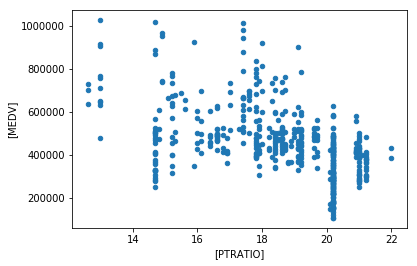

In [5]:
data.plot(x=['PTRATIO'], y=['MEDV'], kind='scatter');

Above is a scatter plot plotted between 'PTRATIO' and 'MEDV'. This plot is scattered over all the places but there is a concentration near the Right Bottom side

It can be understood that Higher the Pupil-Teacher Ratio Lower the Price of Owner-occupied house but it is not that clear with the scatter plot.

Hence, to answer the question, a Home that has a neighbourhood with `'PTRATIO'` value of 20 will have a less worth than that of a Home with neighbourhood with `'PTRATIO'` value of 15.

----

## Developing a Model
In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in our predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

In [6]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

In [7]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


**Question:**
* Would we consider this model to have successfully captured the variation of the target variable? 
* Why or why not?

**Answer:** The r2_score function computes R², the coefficient of determination. It is a statistical measure of how close the data are to the fitted regression line. It provides a measure of how well future samples are likely to be predicted by the model. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

Hence, to answer the question, the R² score of 0.923 is really good, and yes, the model can be used to capture the variation of the target/dependent variable. But of-course there is a scope of improvement as a R² score of 1.0 is the best to be used ideally.

### Implementation: Shuffle and Split Data
Our next implementation requires that we take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [8]:
#Import 'train_test_split'
from sklearn.model_selection import train_test_split

#Shuffle and split the data into training and testing subsets
np_data = np.asarray(data)
X = np_data[:, 0:3]
y = np_data[:, 3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Question 3 - Training and Testing

* What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?

[Under_Fit]: http://localhost:8888/tree/Project/04_Boston_Housing/images/Under_Fit.PNG
[Over_Fit]: http://localhost:8888/tree/Project/04_Boston_Housing/images/Over_Fit.PNG
[Good_Fit]: http://localhost:8888/tree/Project/04_Boston_Housing/images/Good_Fit.PNG
[Table]: http://localhost:8888/tree/Project/04_Boston_Housing/images/table.PNG


**Answer:** A problem in Machine Learning can either be Over-Simplified or Rightly-Solved or Overly-Complicated. Let's understand the above 3 words in detail. The problem of Boston Housing can be solved by a Regression model and hence the example considered are also of the same type.

**Under Fitting Model - Linear Equation of Degree 1**
![alt text][Under_Fit]
It can be observed that a Linear model has been chosen of degree 1 that is considerd as the solution for predicting the dependent variables but this is considered as Under-Fit as it doesn't take into consideration various data and when tested with real values this model would fail.

**Over-Fitting Model - Polynomial Equation of Higher degree**
![alt text][Over_Fit]

It can be observed that this model over fits the data being passed that it memorizes the data and when the real data would be fed it would fail miserably.

**Good-Fitting model - Quadratic Equation of Degree 2.**
![alt text][Good_Fit]

It can be observed that this model fits good as it takes into consideration all values are only draws a line that nearly fits and not under or over fits the data. This when tested would provide a very small error.

But how would we identify if a model Under-Fits, Over-Fits or is a Good Fit ? The answer to this question is dividing the data into Training set and Testing set. If we create a model and if it is a Under Fit the predictions would always be bad, but what if the model created is a Over-Fit or a Good Fit ? In this case we might tend to go with Over-Fit as it produces good results as compared to Good-Fit model. In order to avoid such situation, we should divide the supplied data into Training and Testing set, and should create a model based on only Training set and should use the Testing set to understand the results. If the Evaluation score (R2 Score etc.) is good then alone we will be able to identify if the model is a Over-Fit or a Good Fit.

![alt text][Table]

As it can be understood that a problem can be Over Simplified or Complicated we need to split the provided data into training and testing set as they are real world values and would help to understand the error that a model is giving when tested. The Testing data set would help understand the accuracy of the model

----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing our model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.

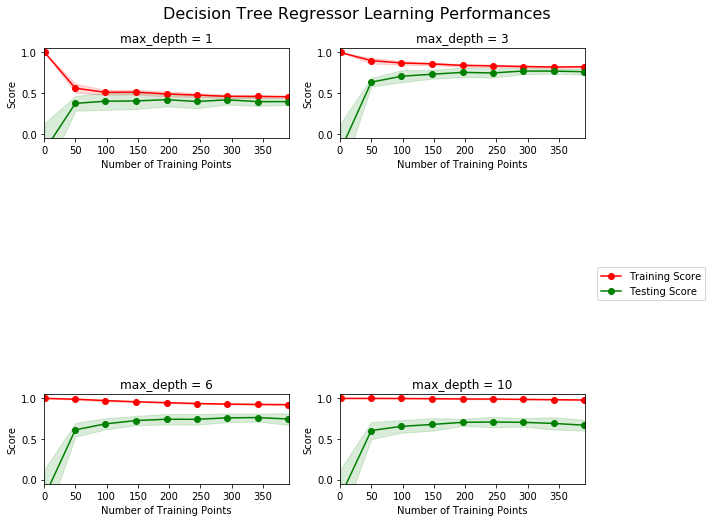

In [9]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4 - Learning the Data

**Answer:** The above graphs are a plot between the scores of train and test data based on R2 Scores. A R2 Score can be between 0 and 1, with 1 being the Best Fit and as the value goes towards 0 the model becomes a bad fit.

From the above 4 graphs, I would like to consider the graph with max_depth as 3 as the Best Fit graph since the Train and Test Scores converge very close at somewhere near 0.80 which is a good score and appears to be a good fit.

Addition of more training points will not matter as the two lines have converged a lot and after this even though we add in more training points the result is going to be the same.

The graph with max_depth as 10 is the Over-Fit Model as the two scores are way apart with Training score at 1.0 and Test Scores somewhere near 0.6. As the max-depth reduces to 6, the model gets better as it can be observed that the two Scores have converged a lot. But when the max_depth is reduced even more the two score lines convered even more with a pretty good R2 Score of 0.80 (approx.). So as to confirm this is a good fit, if we reduce the max_depth to 1, though the two lines appear to converge a lot but the R2 Scores drop to somewhere near 0.45 which proves that the Good Fit for this problem with respect to Decision Tree would be of max_depth 3.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.

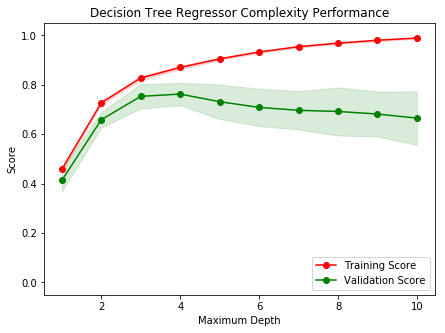

In [10]:
vs.ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
* When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? 
* How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify our conclusions?

**Answer:** The above model with max_depth as 1 is observed to be of High Bias aka Under-Fit model as the Training and Testing Score converge a lot with an average R2 score of 0.5. This means that the Training and Testing data performed in a average manner with both the sets giving errors and is declared to be a Under-Fit model. Also the Complexity performance graph shows that at max_depth as 1 the R2 Score is somewhere near 0.5 which is an average score of R2.

The model with max_depth as 10 is observed to be of High Variance aka Over-Fit model as the Training Score line remains close to 0.95 and the Testing Score line stays far apart at 0.65, they do not converge closer either. This means that the model with max_depth of 10 has memorized the Training data and when the Testing data is provided for Cross Validation it doesn't perform good. The same can be understood from the Complexity Performance curve too, the two lines are far apart and testing set produced high errors in predictions.

Also as per Complexity graph if the lines are diverging farther apart the farther point is considered to be the Over-Fit point and the point from it began diverging is the Good-Fit point.

### Question 6 - Best-Guess Optimal Model
* Which maximum depth do we think results in a model that best generalizes to unseen data? 
* What intuition lead we to this answer?

**Answer:** The model with the max_depth of 3 is a Good Fit or the Best model as the Training & Testing Score lines converge deeply somewhere at 0.80 (approx.). As the number of training points increases the Training score reduces from 1.0 to 0.80 and the Testing score increases from 0 to 0.80 and this proves that the model with max_depth of 3 is the best model to work with.

As per Complexity Graph the point where the two lines diverge is considered to be the best point for Best Fit and as per this graph the two lines start diverging at max_depth 3.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
* What is the grid search technique?
* How it can be applied to optimize a learning algorithm?

**Answer:** A model can have 1 or more Hyper Parameters, if there is only 1 Hyper Parameter then the Complexity Performance Graph was more than sufficient, now what should be done when the model has multiple Hyper Parameters ? The answer is Grid Search Technique.

Grid Search Technique is an algorithm, with the help of which we can tune multiple hyper-parameters of a model. We pass the hyper-parameters to tune, the possible values for each hyper-parameter and a performance metric as input to the grid search algorithm. The algorithm will then place all the possible hyper-parameter combination in a grid and then find the performance of the model for each combination against some cross-validation set. Then it outputs the hyper-parameter combination that gives the best result.

The input of the Grid Search Technique is as follows:
<ol>
    <li>an estimator (regressor or classifier such as sklearn.svm.SVC());</li>
    <li>a parameter space;</li>
    <li>a method for searching or sampling candidates;</li>
    <li>a cross-validation scheme; and</li>
    <li>a score function.</li>
</ol>

In the above model and exercise the only Hyper Parameter we considered was max_depth and hence with varied max_depth we figured out which max_depth value produces better Training & Testing R2 Score.

For example, let's consider the Decision Tree algorithm, and in that let's consider 3 hyper parameters namely max_depth, min_samples_split and min_samples_leaf. In order to do a Grid Search we will be constructing a 3 Dimensional Table with one dimension taken by one Hyper Parameter and then with the exponential values of them we will be finding the R2 Score just the way Cross Validation Technique was done with 1 Hyper Parameter. Now the combination that produces the best R2 Score would be chosen as the result of Grid Search Technique.

### Question 8 - Cross-Validation
* What is the k-fold cross-validation training technique? 
* What benefit does this technique provide for grid search when optimizing a model?

**Answer:** In order to create a Good Model, we create a Bigger Training Set, a Smaller Cross Validation Set and a Smaller Testing Set, the Training set is used to create a Model, Cross Validation set to cross validate and Testing Set is used to test the model for accuracy. Here as it can be well observed that there is a huge probability of we missing out crucual data in the Testing set, which is always thrown away, which if used otherwise would have created a better model. Hence in-order to not miss crucial data k-fold cross validation helps to do the job.

K is a count and K-fold CV mean we create k buckets and then we do the Cross Validation k times by using different buckets everytime, this actually means that we will be doing a Round Robin of all k buckets k time so that we run CV on all combinations and produce even more better model.

Well there is an additional thing that could be done on the same is to Shuffle the items withing the buckets too, but am not sure how fruitful that would be.

Let's say that we have 15 data, and if we mention 25% as Testing set then 12 will be in Training + Cross Validation set and 3 would be in Testing set. Now with k=4, we would create 4 buckets, with the first 3 buckets having Training set and last bucket having Testing set. After every Cross Validation we rotate the bucket line and do it 4 times as k=4. After 4 rotations, we get a list of R2 Score, now the highest score would be chosen to create the model.

Now a combination of k-fold, Cross Validation & Grid Search would help us find the best model which can be productionalized.

### Implementation: Fitting a Model
Our final implementation requires that we bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will find our implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique we describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While we're working on our implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

For the `fit_model` function in the code cell below, we will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.20/modules/generated/sklearn.model_selection.GridSearchCV.html) from `sklearn.model_selection` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [11]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(r2_score)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model

* What maximum depth does the optimal model have? How does this result compare to our guess in **Question 6**?

In [12]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


**Answer:** With the set of max_depths that we analyzed above, we found that max_depth of 3 was better among a 1, 3, 6, 10. Now that we are analyzing a bit deeper with k-fold, CV and Grid Search Technique it is observed that we would have lost some crucial data in the Testing set if we would have ignored that. With the inclusion of even Testing set as a combination the best model can be made with a max_depth of 4. Hence mere Cross Validation of data is not enough but a combination of K-Fold, Grid Search, and Cross Validation technique is required for better results

### Question 10 - Predicting Selling Prices
Imagine that we were a real estate agent in the Boston area looking to use this model to help price homes owned by our clients that they wish to sell. We have collected the following information from three of our clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would we recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

In [13]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


In [14]:
data.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


**Answer:** Let's explain the Clients why they should sell their houses with the Predicted values, but if they can sell it a bit higher then it is a jackpot:

**Client 1: 403,025.00** - The Mean Selling Price of House is $454k. At 403k this home is close to the mean price of Houses. With 5 rooms and a relatively low neighborhood poverty level, which is also equal to the mean, and student-teacher ratio, this is a good selling price.

**Client 2: 237,478.72** - The Selling price predicted is a good prediction and is way higher than the minimum selling price which is just over $100k. The Poverty Ratio and the Pupil Teacher Ratio of this house are almost equal to the Minimum values in the segment but still the price of House is quite high as there are 4 rooms in the House. This is definitely a good deal if gets succeeded.

**Client 3: 931,636.36** - With such a high number of rooms, equalling the maximum and such a low Low Status ration and Pupil Teacher ratio which almost equals the minimum value, this price is decently good.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [15]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


The above predicted values is only from the First Client as per the Code written in `visuals.py`

### Question 11 - Applicability

* In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.

**Answer:** Hence the Model with max_depth as 4 would provide the best model for prediction.

Let's understand further points as well:

<ol>
    <li>This model takes into account of the data that was captured from 1978 and cannot be applied for 2019. Inflation is very important as it increases yearly and with a higher degree everytime.</li>
    <li>The current model cannot be consistent across City area either as the data is collected for Boston, Massachusetts, the same cannot be applied for Texas region or for Indian Cities.</li>
    <li>Moreover the features that we have taken into account are very less, we did not consider many other features, such as area of Hall, presence of private Swimming Pool, presence of Fitness area, presence of Garden area and many more.</li>
    <li>What if there is a Thermal Power Station near the locality then the price of the house really gets lower because of the pollution level. Tuticorin's real estate has gone really down because of Sterlite.</li>
</ol>

The data that we have been supplied with doesn't take into account numerous things. With 1978 as year, Boston as City, with limited features this cannot be applied to a real world problem. But Yes, if we can create a Robust model with numerous features and with the data collected until 2018, we could have predicted far better.